In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)


In [2]:
path = 'data/UserFeedbackData.csv'
df = pd.read_csv(path, index_col=0)
APP_NAME = 'TikTok'
df = df[df['app_name'] == APP_NAME]
df.sort_values(by=['RC_ver'], inplace=True)
df.head()

,content,score,TU_count,app_id,app_name,RC_ver
review_id,,,,,,
1_825,"Unfortunately, there are too many bugs, likes ...",2,13878,com.zhiliaoapp.musically,TikTok,27.8.4
1_966,This app is amazing. I came Errors occur while...,5,47674,com.zhiliaoapp.musically,TikTok,27.9.4
1_824,The app is great for watching really entertain...,3,8440,com.zhiliaoapp.musically,TikTok,27.9.41
1_823,I'm having an issue with adding music to photo...,3,11762,com.zhiliaoapp.musically,TikTok,28.5.6
1_930,honestly TikTok used to be really good but now...,1,5555,com.zhiliaoapp.musically,TikTok,28.5.6


## Visualize Trends ##

As an exercise of further understanding the dataset, or feedback in general, first we try to visualize if there is any trends in terms of ratings vs time. 

Ideally we would see that as time goes on, the user would be more satisfied with the app, more excited about new features. But let's see if that assumption holds

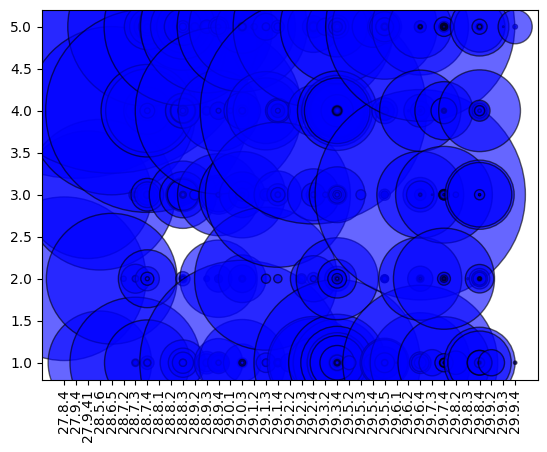

In [3]:

plt.xticks(rotation=90)
# Create scatter plot
plt.scatter(df['RC_ver'].values, df['score'].values, s=df['TU_count'].values, c='blue', alpha=0.6, edgecolors="black")

Since we don't have the time uploaded of the review, we'd use sorted version names as a proxy for time. First I plot the scores against the versions, with the number of thumbs-ups as weights to determine the area of the dot. 

However, I forgot it was discrete scores, so it made this beautiful, but useless plot.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_828\3472515729.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title='Thumbs Up Counts')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_828\3472515729.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(title='Review Counts')


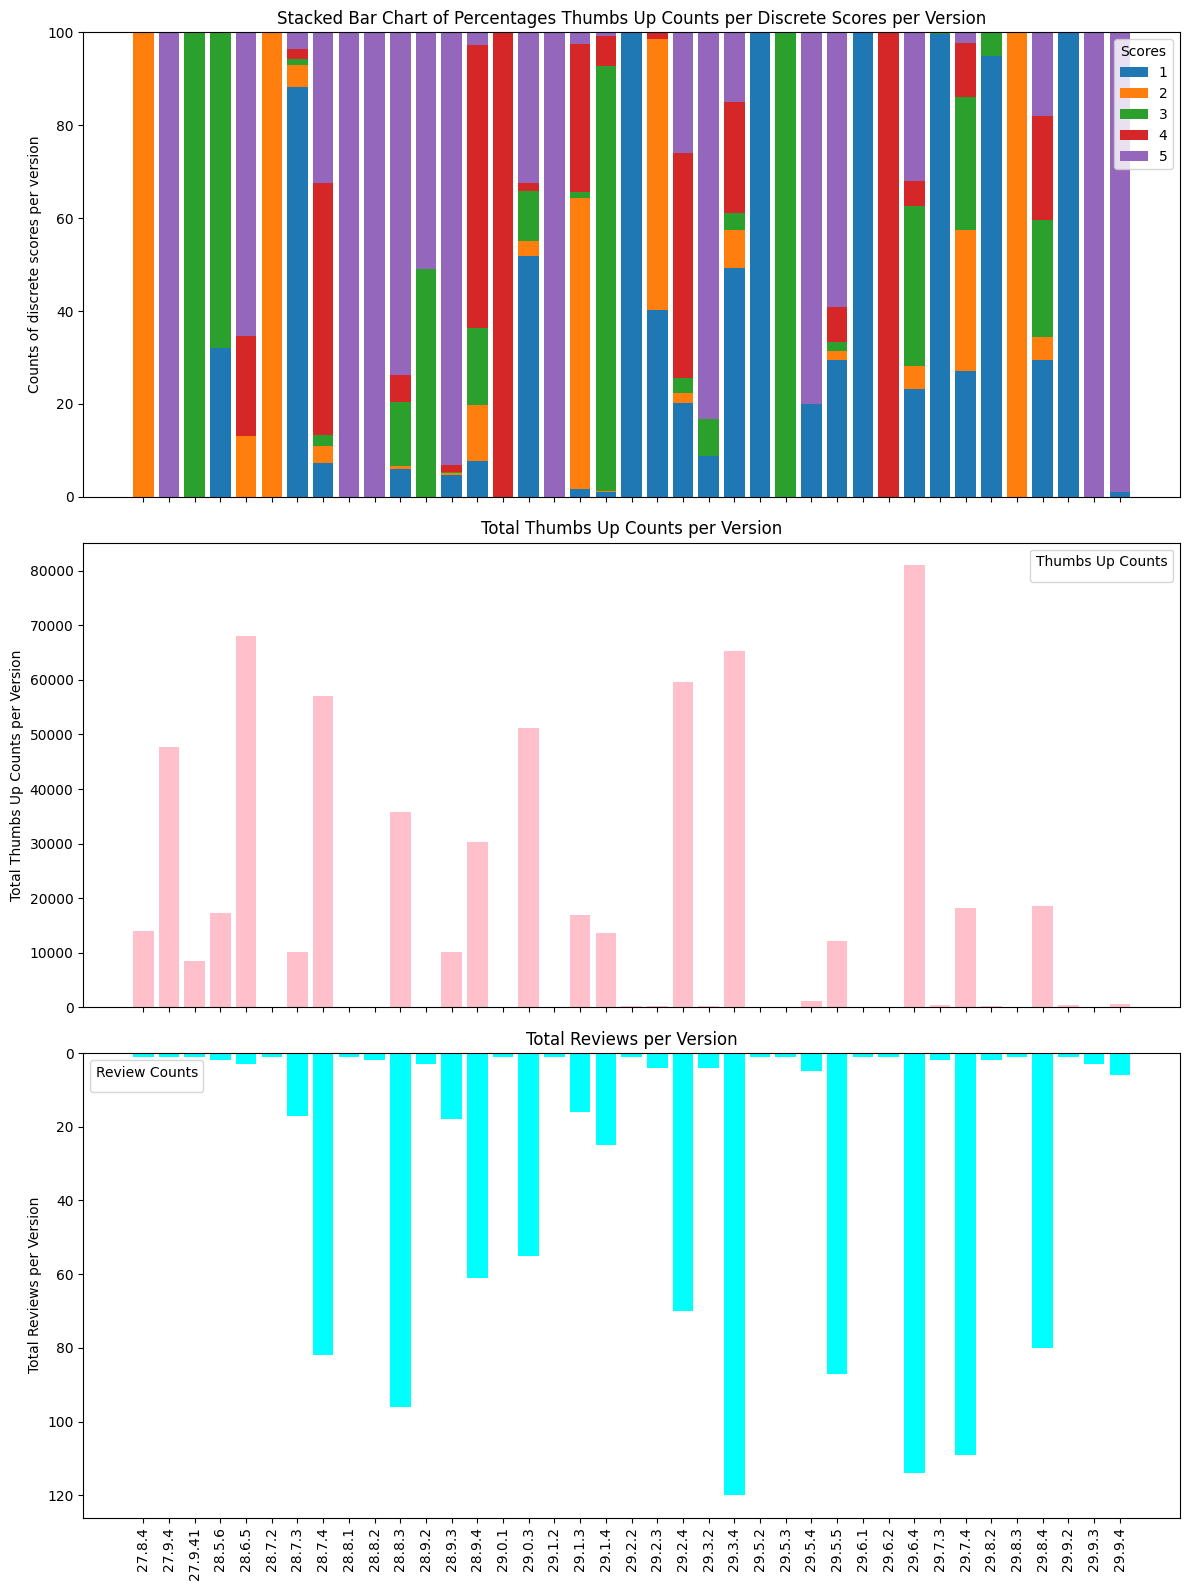

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate thumbsups per scores and rc version
categories = sorted(df['score'].unique())
rc_ver = sorted(df['RC_ver'].unique())

review_counts_per_ver = []
tu_counts_per_ver = []
for ver in rc_ver:
    cur_tu_counts = []
    cur_review_counts = []
    for cat in categories:
        cur_df = df[(df['score'] == cat) & (df['RC_ver'] == ver)]
        cur_tu_counts.append(cur_df['TU_count'].sum())
        cur_review_counts.append(len(cur_df))
    review_counts_per_ver.append(cur_review_counts)
    tu_counts_per_ver.append(cur_tu_counts)

# Convert to percentages
tu_counts_per_ver = np.array(tu_counts_per_ver)
review_counts_per_ver = np.array(review_counts_per_ver)
score_percent = tu_counts_per_ver / tu_counts_per_ver.sum(axis=1, keepdims=True) * 100

# Init plot
fig, (ax1, ax2, ax3)  = plt.subplots(3,1, sharex=True, figsize=(12, 16))
bottom = np.zeros(len(rc_ver))  # Start with zeros
for i in range(tu_counts_per_ver.shape[1]):  # Iterate over each group
    ax1.bar(rc_ver, score_percent[:, i], label=categories[i], bottom=bottom)
    bottom += score_percent[:, i]  # Update bottom for stacking

ax1.set_ylabel('Counts of discrete scores per version')
ax1.set_title('Stacked Bar Chart of Percentages Thumbs Up Counts per Discrete Scores per Version')
ax1.legend(title='Scores')

# Second plot
ax2.bar(rc_ver, tu_counts_per_ver.sum(axis=1, keepdims=True).ravel(), color='pink')
ax2.set_ylabel('Total Thumbs Up Counts per Version')
ax2.set_title('Total Thumbs Up Counts per Version')
ax2.legend(title='Thumbs Up Counts')

# Third plot
ax3.bar(rc_ver, review_counts_per_ver.sum(axis=1, keepdims=True).ravel(), color='cyan')
ax3.invert_yaxis()  # Invert the y-axis
ax3.set_ylabel('Total Reviews per Version')
ax3.set_title('Total Reviews per Version')
ax3.legend(title='Review Counts')

plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


This is much more what I was hoping to see. I plot 3 figures against release versions, and put them on top of each other.
The distribution of scores (by percentage) per version (not by review counts by thumbs-up counts), mapped against the actual counts of the thumbs ups.

At a glance, we find some really intuitive things:
- The more thumbsups/reviews a version got, the more controversial the version was (disagreements of scores among reviews). My assumption is that people only do reviews when they are
- Except for the earlier versions of the app... Uhmmmm interesting, Tiktok, did u hire bots to boost your ratings?

=> You can napkin-test the observation about the thumbsup/review counts vs controversiality actually. Considering the distribution of scores to be a probability distribution, how controversial a version is would be the entropy of the ratings. If everyone agrees that a version is, let's say, 3, then probability distribution would be `[0,0,1,0,0]`, which would make the entropy to be `0`, minimal. But if everyone disagree, the prob dist would look something like `[0.2,0.2,0.2,0.2,0.2]`, making the entropy `2.32`. We can plot the entropy, review counts and TU_counts against each other.

In [5]:
import numpy as np

def get_entropy(probs):
    probs = probs / np.sum(probs)
    probs = probs[probs > 0]  # Remove zero probabilities to avoid log(0) issues
    return -np.sum(probs * np.log2(probs))

print('Entropy of uniform distribution: ', get_entropy(np.array([0.32,0.32, 0.36])))
print('Entropy of a sure choice: ', get_entropy(np.array([1,0, 0, 0])))
# entropy = get_entropy(values_percent.sum(axis=1, keepdims=True).ravel())

Entropy of uniform distribution:  1.582683189255492
Entropy of a sure choice:  -0.0


In [6]:
score_entropy_per_ver = [get_entropy(x) for x in score_percent]
total_tu_counts_per_ver = tu_counts_per_ver.sum(axis=1, keepdims=True).ravel()
total_review_counts_per_ver = review_counts_per_ver.sum(axis=1, keepdims=True).ravel()

In [7]:
average_scores_per_ver = (np.array(categories)*score_percent).sum(axis = 1)/100


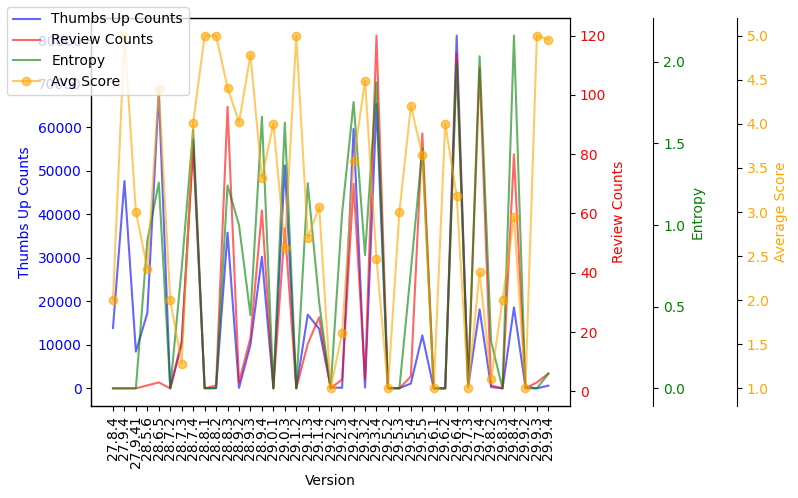

In [8]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Primary Y-axis (Thumbs Up Counts)
ax1.set_xlabel("Version")
ax1.set_ylabel("Thumbs Up Counts", color="blue")
ax1.plot(rc_ver, total_tu_counts_per_ver, c="blue", alpha=0.6, label="Thumbs Up Counts")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xticks(rc_ver) 
ax1.set_xticklabels(rc_ver, rotation=90)  

# Secondary Y-axis (Review Counts)
ax2 = ax1.twinx()
ax2.set_ylabel("Review Counts", color="red")
ax2.plot(rc_ver, total_review_counts_per_ver, c="red", alpha=0.6, label="Review Counts")
ax2.tick_params(axis="y", labelcolor="red")

# Tertiary Y-axis (Entropy)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Move third axis outward for clarity
ax3.set_ylabel("Entropy", color="green")
ax3.plot(rc_ver, score_entropy_per_ver, c="green", alpha=0.6, label="Entropy")
ax3.tick_params(axis="y", labelcolor="green")


# Tertiary Y-axis (Entropy)
color = 'orange'
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120))  
ax4.set_ylabel("Average Score", color=color)
ax4.plot(rc_ver, average_scores_per_ver, c=color, alpha=0.6, label="Avg Score",marker='o' )
ax4.tick_params(axis="y", labelcolor=color)

fig.legend(loc="upper left")

plt.tight_layout()
plt.show()


In [9]:
print('Pearson Correlation between :')
print('Thumbs Up Counts and Review Counts: ', np.corrcoef(total_tu_counts_per_ver, total_review_counts_per_ver)[0][1])
print('Thumbs Up Counts and Entropy: ', np.corrcoef(total_tu_counts_per_ver, [get_entropy(x) for x in score_percent])[0][1])
print('Review Counts and Entropy: ', np.corrcoef(total_review_counts_per_ver, [get_entropy(x) for x in score_percent])[0][1])
print('====')
print('Average Score and Entropy: ', np.corrcoef(average_scores_per_ver, [get_entropy(x) for x in score_percent])[0][1])
print('Thumbs Up Counts and Average Score: ', np.corrcoef(total_tu_counts_per_ver, average_scores_per_ver)[0][1])

Pearson Correlation between :
Thumbs Up Counts and Review Counts:  0.6797476709322346
Thumbs Up Counts and Entropy:  0.6877611217609798
Review Counts and Entropy:  0.8452718303390699
====
Average Score and Entropy:  0.04209666114561273
Thumbs Up Counts and Average Score:  0.15945576138720244


We see the entropy spiked almost always when review/thumbsups counts spike. In fact, the Pearson Correlation between the counts with entropy is significant, `0.68` and `0.84`. So my observation looks good, that the more controversial a version is, the more people will come in and review.

While the more trivial correlation, a positive one between TU_Counts and Review counts, just implies that people do review when they have something to say, and people check the app's reviews and interact with them (thumbs up), when they have something to say about the app. I should also note that I have no idea how this data was collected, as the curators do not give much info, so there may be a huge [survivorship bias](https://en.wikipedia.org/wiki/Survivorship_bias) in play here.

So what about cases where this is not true, when everyone agrees even though there is low review counts?

In [10]:
weird_ids = [i for i in range(len(score_entropy_per_ver)) if score_entropy_per_ver[i] < 0.8 and total_review_counts_per_ver[i] > 1]
weird_ver = [rc_ver[i] for i in weird_ids]
temp_df = pd.DataFrame({
    'RC_ver': rc_ver, 
    'TU_counts': total_tu_counts_per_ver, 
    'Review_counts': total_review_counts_per_ver, 
    'Entropy': [round(x, 2) for x in score_entropy_per_ver], 
    "Average score": [round(x, 2) for x in average_scores_per_ver]
    })
temp_df = temp_df[temp_df['RC_ver'].isin(weird_ver)]
temp_df
# print('Version, Total Thumbs Up Counts, Total Review Counts, Entropy')
# for i in weird_ids:
#     print(rc_ver[i], total_tu_counts_per_ver[i], total_review_counts_per_ver[i], round(score_entropy_per_ver[i], 2), round(average_scores_per_ver[i], 2))

,RC_ver,TU_counts,Review_counts,Entropy,Average score
6,28.7.3,10142,17,0.74,1.28
9,28.8.2,78,2,-0.00,5.00
12,28.9.3,10029,18,0.45,4.78
18,29.1.4,13652,25,0.52,3.06
26,29.5.4,1098,5,0.72,4.20
31,29.7.3,358,2,0.03,1.01
33,29.8.2,298,2,0.29,1.10
37,29.9.3,2,3,-0.00,5.00
38,29.9.4,622,6,0.09,4.95


I guess if there was only 1 review, the entropy being extremely low makes sense, cuz there was only 1 score. And personally, I don't consider having 2-6 reviews where they all agree abnormalies, as they gather mostly under 1000 thumbs up anyway. From now on, I will throw all versions without more than 10 reviews away

I'm more interested in reviews that makes up the 17-25 reviews that totals up to 10,000 thumbs ups. Let's dig in more.

In [11]:
temp_df = df[df['RC_ver'].isin(['28.7.3', '28.9.3', '29.1.4']) & (df['TU_count'] > 500)]
temp_df

,content,score,TU_count,app_id,app_name,RC_ver
review_id,,,,,,
1_28,"App is great, but recently for some reason its...",1,8898,com.zhiliaoapp.musically,TikTok,28.7.3
1_132,This app is amazing. I come Errors accur while...,5,9070,com.zhiliaoapp.musically,TikTok,28.9.3
1_63,"For the most part, a pleasant experience. I ju...",3,1167,com.zhiliaoapp.musically,TikTok,29.1.4
1_23,"I spend most of my day on this app, and it's g...",3,10908,com.zhiliaoapp.musically,TikTok,29.1.4


In [12]:
for i in temp_df.index:
    print(temp_df.loc[i]['content'])

App is great, but recently for some reason its not letting me switch my images to photo mode, the button that's supposed to be on the bottom middle of the screen doesn't show up, so I can't upload the photos I want to, I've tried everything I know, unistalling, reinstalling, checking for updates, litrslly everything yet for some reason its just not showing up, and other people have the same issue as me. Can you fix this?
This app is amazing. I come Errors accur while using the app. For the example when you press the button to record. Video with sounds🔊 when the sound plays. The camera is only site never been like this. This the error is happening for about 1 mouth. And a half. Some time it's works but not often. I Anyway record video anytime but I do. However post bro. Viral my videos 📝thanks. Criket video 📹post in anytime thanks
For the most part, a pleasant experience. I just wish Stitch's were maybe a little longer like 10 seconds. And I have a gripe with the 10 minute option. The o

Wow, those are legit reviews. I was honestly expecting bad behavior (bots, trolling, review bombs...), but these are legitimate concerns. Guess we have a very curated and high quality dataset on our hands.

In [13]:
filter_ids = [i for i in range(len(score_entropy_per_ver)) if total_review_counts_per_ver[i] < 10]
print(filter_ids)

[0, 1, 2, 3, 4, 5, 8, 9, 11, 14, 16, 19, 20, 22, 24, 25, 26, 28, 29, 31, 33, 34, 36, 37, 38]


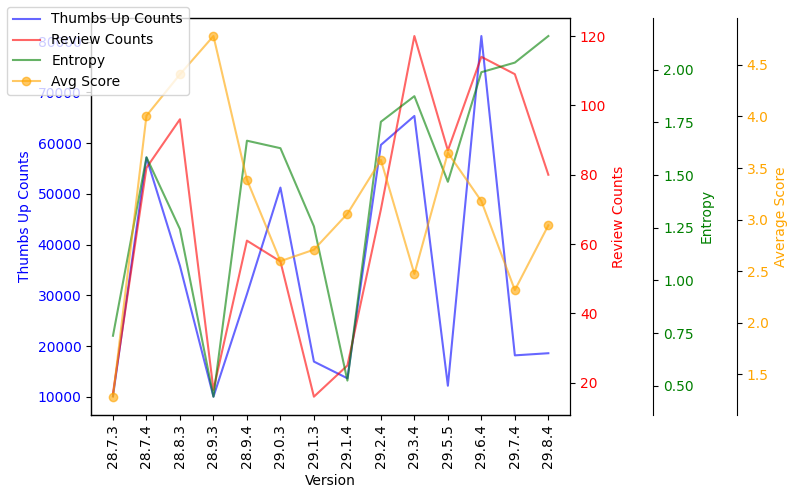

In [14]:
# Create figure and primary axis
rc_ver_filtered = [rc_ver[i] for i in range(len(rc_ver)) if i not in filter_ids]
total_tu_counts_per_ver_filtered = [total_tu_counts_per_ver[i] for i in range(len(rc_ver)) if i not in filter_ids]
total_review_counts_per_ver_filtered = [total_review_counts_per_ver[i] for i in range(len(rc_ver)) if i not in filter_ids]
score_entropy_per_ver_filtered = [score_entropy_per_ver[i] for i in range(len(rc_ver)) if i not in filter_ids]
average_scores_per_ver_filtered = [average_scores_per_ver[i] for i in range(len(rc_ver)) if i not in filter_ids]


fig, ax1 = plt.subplots(figsize=(8, 5))

# Primary Y-axis (Thumbs Up Counts)
ax1.set_xlabel("Version")
ax1.set_ylabel("Thumbs Up Counts", color="blue")
ax1.plot(rc_ver_filtered, total_tu_counts_per_ver_filtered, c="blue", alpha=0.6, label="Thumbs Up Counts")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xticks(rc_ver) 
ax1.set_xticklabels(rc_ver, rotation=90)  

# Secondary Y-axis (Review Counts)
ax2 = ax1.twinx()
ax2.set_ylabel("Review Counts", color="red")
ax2.plot(rc_ver_filtered, total_review_counts_per_ver_filtered, c="red", alpha=0.6, label="Review Counts")
ax2.tick_params(axis="y", labelcolor="red")

# Tertiary Y-axis (Entropy)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Move third axis outward for clarity
ax3.set_ylabel("Entropy", color="green")
ax3.plot(rc_ver_filtered, score_entropy_per_ver_filtered, c="green", alpha=0.6, label="Entropy")
ax3.tick_params(axis="y", labelcolor="green")


# Tertiary Y-axis (Entropy)
color = 'orange'
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 120))  
ax4.set_ylabel("Average Score", color=color)
ax4.plot(rc_ver_filtered, average_scores_per_ver_filtered, c=color, alpha=0.6, label="Avg Score",marker='o' )
ax4.tick_params(axis="y", labelcolor=color)

fig.legend(loc="upper left")

plt.tight_layout()
plt.show()


In [15]:
print('Pearson Correlation between :')
print('Thumbs Up Counts and Average Score: ', np.corrcoef(total_tu_counts_per_ver_filtered, average_scores_per_ver_filtered)[0][1])
print('Review Counts and Average Score: ', np.corrcoef(total_review_counts_per_ver_filtered, average_scores_per_ver_filtered)[0][1])
print('Entropy and Average Score: ', np.corrcoef(score_entropy_per_ver_filtered, average_scores_per_ver_filtered)[0][1])

Pearson Correlation between :
Thumbs Up Counts and Average Score:  0.08181588337142724
Review Counts and Average Score:  0.07645626956648324
Entropy and Average Score:  -0.16789718015653404


Seems like after digging into outliers and removing versions without a lot of reviews, there is still no correlation between average scores and review counts, TU_counts or entropy. It does seems like taking a look from a macro perspective will not give us a lot of answers. What we know is that:


In [35]:
# Get versions that has the largest amount of entropy

top_entropies = np.argsort(score_entropy_per_ver_filtered)
print('Top 3 versions that has the largest amount of entropy: ', np.array(rc_ver_filtered)[top_entropies[-3:]], np.array(score_entropy_per_ver_filtered)[top_entropies[-3:]])


Top 3 versions that has the largest amount of entropy:  ['29.6.4' '29.7.4' '29.8.4'] [1.98817247 2.03365052 2.15985359]


In [32]:
# Get versions that experience the largest drop in average score
diff_scores = [float(round(average_scores_per_ver_filtered[i] - average_scores_per_ver_filtered[i-1], 2)) for i in range(1, len(average_scores_per_ver_filtered))]
diff_entropy = [float(round(score_entropy_per_ver_filtered[i] - score_entropy_per_ver_filtered[i-1], 2)) for i in range(1, len(score_entropy_per_ver_filtered))]
# print(len(diff_scores), len(rc_ver_filtered))
print([(x, y, z) for x, y,z in zip(rc_ver_filtered[1:], diff_scores, diff_entropy)])
argsort_score = np.argsort(diff_scores)
argsort_entropy = np.argsort(diff_entropy)
print('Top 3 versions that experience the largest increase in average score: ',  np.array(rc_ver_filtered[1:])[argsort_score[-3:]], np.array(diff_scores)[argsort_score[-3:]])
print('Top 3 versions that experience the largest decrease in average score: ',  np.array(rc_ver_filtered[1:])[argsort_score[:3]], np.array(diff_scores)[argsort_score[:3]])

print('Top 3 versions that experience the largest increase in entropy: ',  np.array(rc_ver_filtered[1:])[argsort_entropy[-3:]], np.array(diff_entropy)[argsort_entropy[-3:]])
print('Top 3 versions that experience the largest decrease in entropy: ',  np.array(rc_ver_filtered[1:])[argsort_entropy[:3]], np.array(diff_entropy)[argsort_entropy[:3]])

[('28.7.4', 2.73, 0.85), ('28.8.3', 0.4, -0.34), ('28.9.3', 0.37, -0.8), ('28.9.4', -1.39, 1.22), ('29.0.3', -0.79, -0.04), ('29.1.3', 0.11, -0.37), ('29.1.4', 0.35, -0.73), ('29.2.4', 0.52, 1.23), ('29.3.4', -1.11, 0.12), ('29.5.5', 1.18, -0.41), ('29.6.4', -0.47, 0.52), ('29.7.4', -0.86, 0.05), ('29.8.4', 0.63, 0.13)]
Top 3 versions that experience the largest increase in average score:  ['29.8.4' '29.5.5' '28.7.4'] [0.63 1.18 2.73]
Top 3 versions that experience the largest decrease in average score:  ['28.9.4' '29.3.4' '29.7.4'] [-1.39 -1.11 -0.86]
Top 3 versions that experience the largest increase in entropy:  ['28.7.4' '28.9.4' '29.2.4'] [0.85 1.22 1.23]
Top 3 versions that experience the largest decrease in entropy:  ['28.9.3' '29.1.4' '29.5.5'] [-0.8  -0.73 -0.41]


In [17]:
print(1)

1
